<a href="https://colab.research.google.com/github/abdullah345/Deep-Learning-with-keras/blob/master/Image_Classification_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Computer to Differentiate Cats

In [0]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras import regularizers
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

%matplotlib inline
np.random.seed(1)

Using TensorFlow backend.


In [0]:
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

## 1 - Overview of the data set

First of all, we'll load the data. After loading, here's a basic overview;

- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

In [0]:
train_dataset = h5py.File('train.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

test_dataset = h5py.File('test.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

In [0]:
classes = np.array(test_dataset["list_classes"][:]) # the list of classes
classes

array([b'non-cat', b'cat'], dtype='|S7')

In [0]:
train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
print(train_set_y.shape)
print(test_set_y.shape)

(1, 209)
(1, 50)


Each line of train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the index value and re-run to see other images.

y = [1], it's a 'cat' picture.


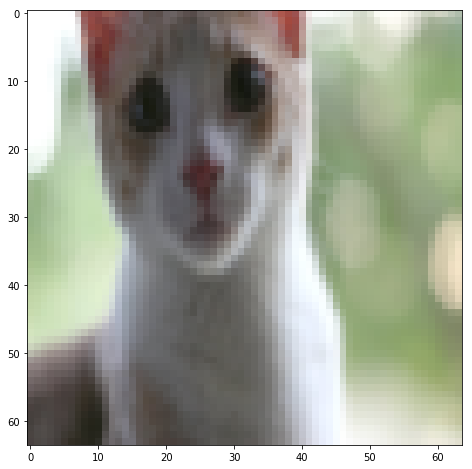

In [0]:
# Example of a picture
index = 135
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

## 2 - Data preprocessing

Common steps for pre-processing a new dataset are:

- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px * num_px * 3, 1)
- "Standardize" the data

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs.

### 2.1 Dimensions of our data

In [0]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Dataset dimensions:")
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")

Dataset dimensions:
Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)


In [0]:
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


### 2.2 Reshaping data

For convenience, we now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use:

    X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X

In [0]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)
train_set_y = train_set_y.T
test_set_y = test_set_y.T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (209, 12288)
train_set_y shape: (209, 1)
test_set_x_flatten shape: (50, 12288)
test_set_y shape: (50, 1)


### 2.3 Standardizing data

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

Let's standardize our dataset.

In [0]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [0]:
train_set_x.shape

(209, 12288)

## 3 - Modeling

In [0]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [0]:
# Utility function
def evaluate_this_model(model, epochs):
    history = model.fit(train_set_x, train_set_y, epochs=epochs)
    results = model.evaluate(test_set_x, test_set_y)
    
    plt.plot(np.squeeze(history.history["loss"]))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    print("\n\nAccuracy on training set is {}".format(history.history["acc"][-1]))
    print("\nAccuracy on test set is {}".format(results[1]))

### 3.1 Starting with a basic model

In [0]:
model = Sequential()

model.add(Dense(units=25, activation='relu', input_dim=train_set_x_flatten.shape[1]))
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [0]:
learning_rate = 0.0001
opt = Adam(lr=learning_rate)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50
209/209 [==============================] - 5s 22ms/step - loss: 0.6789 - acc: 0.5885
Epoch 2/50
209/209 [==============================] - 0s 252us/step - loss: 0.6461 - acc: 0.6507
Epoch 3/50
209/209 [==============================] - 0s 264us/step - loss: 0.6417 - acc: 0.6507
Epoch 4/50
209/209 [==============================] - 0s 260us/step - loss: 0.6339 - acc: 0.6507
Epoch 5/50
209/209 [==============================] - 0s 241us/step - loss: 0.6238 - acc: 0.6507
Epoch 6/50
209/209 [==============================] - 0s 253us/step - loss: 0.6200 - acc: 0.6507
Epoch 7/50
209/209 [==============================] - 0s 282us/step - loss: 0.6094 - acc: 0.6507
Epoch 8/50
209/209 [==============================] - 0s 258us/step - loss: 0.6054 - acc: 0.6507
Epoch 9/50
209/209 [==============================] - 0s 265us/step - loss: 0.6067 - acc: 0.6507
Epoch 10/50
209/209 [==============================] - 0s 263us/step - loss: 0.5928 - acc: 0.6459
Epoch 11/50
209/209 [========

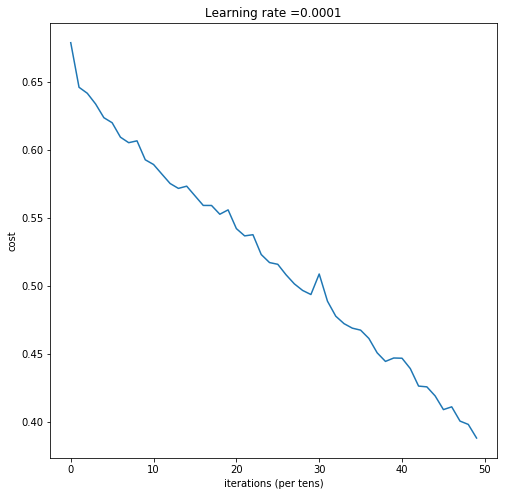



Accuracy on training set is 0.8947368426756426

Accuracy on test set is 0.6199999976158143


In [0]:
h = evaluate_this_model(model, 50)

### 3.2 Improving the basic Model

___Objective:___ Design and tune a feed forward deep learning model to achieve at least ___75% accuracy___ on this dataset.

In [0]:
# Run this cell first
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [0]:
model = Sequential()
model.add(Dense(units=25, activation='relu', input_dim=train_set_x_flatten.shape[1]))

model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=20, activation='relu'))

model.add(Dense(units=10, activation='relu'))

model.add(Dense(units=1, activation='sigmoid'))

In [0]:
learning_rate = 0.0001
opt=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
#opt = Adam(lr=learning_rate)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Epoch 1/75
209/209 [==============================] - 3s 12ms/step - loss: 0.6828 - acc: 0.5789
Epoch 2/75
209/209 [==============================] - 0s 229us/step - loss: 0.6590 - acc: 0.6507
Epoch 3/75
209/209 [==============================] - 0s 226us/step - loss: 0.6533 - acc: 0.6507
Epoch 4/75
209/209 [==============================] - 0s 213us/step - loss: 0.6446 - acc: 0.6507
Epoch 5/75
209/209 [==============================] - 0s 222us/step - loss: 0.6381 - acc: 0.6507
Epoch 6/75
209/209 [==============================] - 0s 220us/step - loss: 0.6400 - acc: 0.6507
Epoch 7/75
209/209 [==============================] - 0s 238us/step - loss: 0.6366 - acc: 0.6507
Epoch 8/75
209/209 [==============================] - 0s 228us/step - loss: 0.6297 - acc: 0.6507
Epoch 9/75
209/209 [==============================] - 0s 236us/step - loss: 0.6355 - acc: 0.6507
Epoch 10/75
209/209 [==============================] - 0s 223us/step - loss: 0.6231 - acc: 0.6555
Epoch 11/75
209/209 [=========

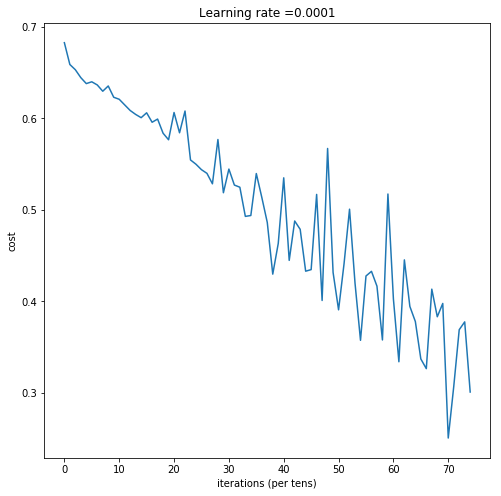



Accuracy on training set is 0.866028708419161

Accuracy on test set is 0.7800000071525574


In [0]:
h = evaluate_this_model(model, 75)